# Word2Vec pipeline showcase

# Introduction

In this notebook we showcase a simple pipeline based on the given implementation of the word2vec library

In [81]:

%cd /home/gordan/Desktop/jetbrains/word2vec_library/notebooks
%cd ..

%load_ext autoreload
%autoreload 2

import sys
import os


import numpy as np
import matplotlib.pyplot as plt

import src.utils as ut
import src.evaluation as ev
import src.preprocessing as pre

from src.sal import SAL
from src.model import SkipGram_Model, CBOW_Model
from src.trainer import train_and_validate

from pathlib import Path


/home/gordan/Desktop/jetbrains/word2vec_library/notebooks
/home/gordan/Desktop/jetbrains/word2vec_library
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/lib/python3/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [61]:
hyperparameters = {
    "lr" : 0.01,
    "num_epochs" : 10,
    "n_samples" : 3,
    "window_size" : 2,
    "train_test_split" : 0.8
}

## Preprocessing the data

The first thing we do is preprocess the data and sample according to the frequencies.

In [76]:
path_to_file = Path('data/')
filename = "alice_in_wonderland.txt"

tokens = pre.preprocess_list(path=path_to_file,filename=filename)
word2idx, idx2word, vocab_size = ut.build_vocab(tokens=tokens)

freqs = ut.compute_word_frequencies(tokens=tokens)
subsampled_tokens = ut.subsample_tokens(tokens=tokens,freqs=freqs,t=1e-2)

print(f"Original number of words: {len(tokens)}")
print(f"New number of words: {len(subsampled_tokens)}")

Original number of words: 26743
New number of words: 16450


## Skip-gram architecture

In [77]:
model = SkipGram_Model(vocab_size=vocab_size,embedded_size=300)
train_and_validate(tokens=subsampled_tokens,word2idx=word2idx,model=model,**hyperparameters)

Epoch 1/10 | Avg Loss: 2.772650
Validation Loss: 0.695546
Epoch 2/10 | Avg Loss: 2.762107
Validation Loss: 0.700791
Epoch 3/10 | Avg Loss: 2.740905
Validation Loss: 0.718907
Epoch 4/10 | Avg Loss: 2.699761
Validation Loss: 0.763101
Epoch 5/10 | Avg Loss: 2.634628
Validation Loss: 0.830752
Epoch 6/10 | Avg Loss: 2.556216
Validation Loss: 0.906605
Epoch 7/10 | Avg Loss: 2.479128
Validation Loss: 0.975339
Epoch 8/10 | Avg Loss: 2.403872
Validation Loss: 1.037565
Epoch 9/10 | Avg Loss: 2.338397
Validation Loss: 1.092859
Epoch 10/10 | Avg Loss: 2.274774
Validation Loss: 1.142954


In [ ]:
model_path = Path('models')
filenames = ['skip_model.npz','skip_wordidx.pkl'] #optional

sal = SAL(model=model,word2idx=word2idx,idx2word=idx2word)
sal.save(path=model_path,filenames=filenames)

## Evaluating the model

In [ ]:
model_path = Path('models')
filenames = ['skip_model.npz','skip_wordidx.pkl'] #optional

sal = SAL.open(model_path)
model, word2idx, idx2word = sal.return_components()

In [80]:
# we are going to evalute some words to test out their neighbourhoods to see whether they are close to the tested out standard
words = ['alice', 'queen', 'rabbit', 'cat', 'king', 'mock', 'caterpillar', 'cheshire']
top_neighbors = 5

for word in words:
    print(f"For the word {word}, these are the nearest {top_neighbors} words:")
    print(ev.get_nearest_neighbors(model=model, word=word,
                                   word2idx=word2idx,idx2word=idx2word,
                                   top_k=top_neighbors))


For the word alice, these are the nearest 5 words:
[('think', 0.30584452873691237), ('did', 0.30239043875607013), ('thought', 0.2691378980721101), ('went', 0.2667475576345343), ('said', 0.2631898564085375)]
For the word queen, these are the nearest 5 words:
[('the', 0.2931607875389563), ('and', 0.26721413265404265), ('only', 0.23752061223292245), ('who', 0.22310049242355237), ('moral', 0.22055362857320557)]
For the word rabbit, these are the nearest 5 words:
[('a', 0.239959189600546), ('was', 0.19488940889339718), ('back', 0.19029538118565847), ('moment', 0.17577204456928797), ('in', 0.1724158213826334)]
For the word cat, these are the nearest 5 words:
[('cheshire', 0.2483053162270373), ('said', 0.20772540100372264), ('look', 0.18725164233294186), ('what', 0.1800126752091062), ('vanished', 0.1797773538480485)]
For the word king, these are the nearest 5 words:
[('queen', 0.3552494355969734), ('look', 0.27208985434064137), ('and', 0.24837032746629475), ('all', 0.20176326321015892), ('the

## Visualization

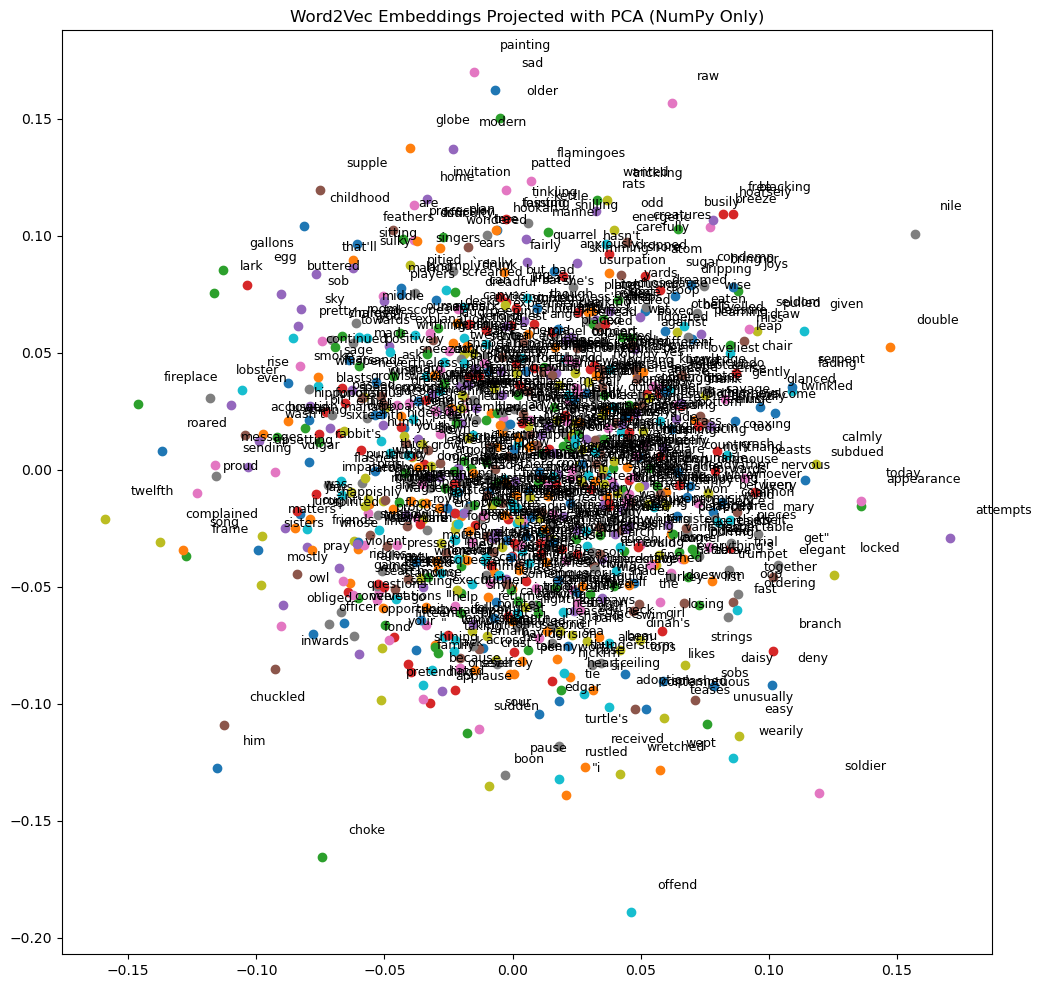

In [ ]:
embeddings = model.W_in

mean_vec = np.mean(embeddings,axis=0)
centered = embeddings - mean_vec

cov = np.cov(centered.T)

eig_vals, eig_vecs = np.linalg.eig(cov)

top2 = eig_vecs[:,-2:]
emb_2d = centered @ top2

plt.figure(figsize=(12,12))
for i, word in enumerate(idx2word.values()):
    if i % 3 == 0:  # optional, to avoid too crowded plot
        x, y = emb_2d[i, 0], emb_2d[i, 1]
        plt.scatter(x, y)
        plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.title("Word2Vec Embeddings Projected with PCA")
plt.show()

## CBOW model

In [ ]:
model = CBOW_Model(vocab_size=vocab_size)
train_and_validate(tokens=subsampled_tokens,word2idx=word2idx,model=model,**hyperparameters)

In [ ]:
model_path = Path('models')
filenames = ['cbow_model.npz','cbow_wordidx.pkl'] #optional

sal = SAL(model=model,word2idx=word2idx,idx2word=idx2word)
sal.save(path=model_path,filenames=filenames)

## Evaluating the model

In [ ]:
model_path = Path('models')
filenames = ['cbow_model.npz','cbow_wordidx.pkl'] #optional

sal = SAL.open(model_path)
model, word2idx, idx2word = sal.return_components()

In [ ]:
# we are going to evalute some words to test out their neighbourhoods to see whether they are close to the tested out standard
words = ['alice', 'queen', 'rabbit', 'cat', 'king', 'mock', 'caterpillar', 'cheshire']
top_neighbors = 5

for word in words:
    print(f"For the word {word}, these are the nearest {top_neighbors} words:")
    print(ev.get_nearest_neighbors(model=model, word=word,
                                   word2idx=word2idx,idx2word=idx2word,
                                   top_k=top_neighbors))


## Visualization

In [ ]:
embeddings = model.W_in

mean_vec = np.mean(embeddings,axis=0)
centered = embeddings - mean_vec

cov = np.cov(centered.T)

eig_vals, eig_vecs = np.linalg.eig(cov)

top2 = eig_vecs[:,-2:]
emb_2d = centered @ top2

plt.figure(figsize=(12,12))
for i, word in enumerate(idx2word.values()):
    if i % 3 == 0:  # optional, to avoid too crowded plot
        x, y = emb_2d[i, 0], emb_2d[i, 1]
        plt.scatter(x, y)
        plt.text(x+0.01, y+0.01, word, fontsize=9)
plt.title("Word2Vec Embeddings Projected with PCA")
plt.show()